<center><a href="https://www.pieriantraining.com/" ><img src="../PTCenteredPurple.png" alt="Pierian Training Logo" /></a></center>


# Поиск знаний - один файл с интерпретатором кода

Давайте рассмотрим, как использовать интерпретатор кода в сочетании с базой знаний.

In [1]:
from openai import OpenAI

In [2]:
client = OpenAI() 

In [4]:
# Make sure you are using at least version 1.3.8 to be able to grab image files!
#!pip install openai --upgrade
import openai
print(openai.__version__)
#assert(openai.__version__ == '1.3.8')

1.28.1


----

## Загрузка файлов

In [5]:
files_to_upload = ['SP500_Prices_5Year.csv']

In [6]:
def upload_assistant_file(filename):
    file = client.files.create(
      file=open(filename, "rb"),
      purpose='assistants'
    )
    print(file.id)

In [8]:
for file in files_to_upload:
    upload_assistant_file(file)

file-VYCIXgLhrqdn5sOuBRd1tMHD


In [5]:
response = client.files.list()
for file in response.data:
    print(f"Имя файла: {file.filename}, ID файла: {file.id}")

Имя файла: SP500_Prices_5Year.csv, ID файла: file-VYCIXgLhrqdn5sOuBRd1tMHD
Имя файла: signs.docx, ID файла: file-9nq5UX3m6hJELK6uZSsaZT6K
Имя файла: plan_in_sign.docx, ID файла: file-ojV1fuoUcfGIeoMZLLCAViaK
Имя файла: plan_upay.docx, ID файла: file-8wFAh1pAqigNn8JX5c4ZNUvd


In [10]:
client.files.delete("file-skxHuQQDOv7WmRKj9iskNyJG")

FileDeleted(id='file-skxHuQQDOv7WmRKj9iskNyJG', deleted=True, object='file')

## Создаем ассистента

In [7]:
# Add the file to the assistant
assistant = client.beta.assistants.create(
  description="Assistant with code interpreter",
  name='Stock Visualizer',
  instructions="You use code and files to help visualize stock data.",
  model="gpt-3.5-turbo-0125",
  temperature=0.3,
  tools=[{"type": "code_interpreter"}],
  tool_resources={"code_interpreter": {"file_ids": ["file-VYCIXgLhrqdn5sOuBRd1tMHD"]}}
)


## Запустите поток и добавьте файл к сообщению

Когда файл прикреплен на уровне сообщения, он доступен только в конкретном потоке, к которому прикреплено сообщение. Загрузив файл, вы можете передать идентификатор этого файла при создании сообщения. Обратите внимание, что плата взимается не за размер файлов, загружаемых через Files API, а за то, какие файлы, прикрепленные к конкретному Assistant или Message, будут проиндексированы.

In [8]:
thread = client.beta.threads.create(
    tool_resources={
        "code_interpreter": {
        "file_ids": [file.id]
        }},
    metadata={
    "Предназначение": "code_interpreter",
    "user": "maks"
  }
)

In [9]:
thread.id

'thread_woCsrGlnzyKKpW3kZglqhZO5'

In [10]:
import pandas as pd

In [ ]:
df = pd.read_csv('SP500_Prices_5Year.csv')
print(df.head())

In [21]:
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you create a plot of the historical Adjusted Closing price of the SP500?",
    attachments = [
    {
        "file_id": "file-VYCIXgLhrqdn5sOuBRd1tMHD",
        "tools": [
            {
                "type": "code_interpreter"
            }
        ]
    }
    ]
)

In [22]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id="asst_OywtDLNTG9xNIr9uzgBqIxdo",
  instructions = "Используй данные из таблицы что бы ответить на вопрос" # This helps to force the model to access the file!
)

In [28]:
run.status

'completed'

In [27]:
# NOTE: Using files and code-interpreter will likely take longer, the assistant needs to run the code!
run = client.beta.threads.runs.retrieve(
          thread_id=thread.id,
          run_id=run.id
        )
    
print(run.status)

completed


Once the run is completed, let's get the messages

In [29]:
messages = client.beta.threads.messages.list(
    thread_id=thread.id, order="asc",
)

## Assistant Returning Files

Note that we asked for a plot, that meands the messages likely contain more than just text!

In [30]:
messages

SyncCursorPage[Message](data=[Message(id='msg_yN1rW5sWX0N53oDeOMqs0jKQ', assistant_id=None, attachments=[Attachment(file_id='file-VYCIXgLhrqdn5sOuBRd1tMHD', tools=[CodeInterpreterTool(type='code_interpreter')])], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='Can you create a plot of the historical Adjusted Closing price of the SP500?'), type='text')], created_at=1715454513, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_woCsrGlnzyKKpW3kZglqhZO5'), Message(id='msg_H8qfGpSKHtI1aI5ABCG6cLjS', assistant_id='asst_OywtDLNTG9xNIr9uzgBqIxdo', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="I will read the contents of the file to determine its structure and identify the data for the Adjusted Closing price of the SP500. Let's take a look at the contents of the file."), type='text')], created_at=1715454732, incomplete_at=None, i

In [31]:
for thread_message in messages:
    print(thread_message)
    print('\n')

Message(id='msg_yN1rW5sWX0N53oDeOMqs0jKQ', assistant_id=None, attachments=[Attachment(file_id='file-VYCIXgLhrqdn5sOuBRd1tMHD', tools=[CodeInterpreterTool(type='code_interpreter')])], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='Can you create a plot of the historical Adjusted Closing price of the SP500?'), type='text')], created_at=1715454513, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_woCsrGlnzyKKpW3kZglqhZO5')


Message(id='msg_H8qfGpSKHtI1aI5ABCG6cLjS', assistant_id='asst_OywtDLNTG9xNIr9uzgBqIxdo', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="I will read the contents of the file to determine its structure and identify the data for the Adjusted Closing price of the SP500. Let's take a look at the contents of the file."), type='text')], created_at=1715454732, incomplete_at=None, incomplete_details=None, metad

In [33]:
# GRAB ONLY THAT LAST MESSAGE WITH THE IMAGE
# ALTERNATIVELY USE after parameter when listing messages to only grab last message
message = client.beta.threads.messages.retrieve(
  message_id='msg_yYQE0dGYOuKgVIgMZiVWZ6wV',
  thread_id=thread.id,
)

In [34]:
message

Message(id='msg_yYQE0dGYOuKgVIgMZiVWZ6wV', assistant_id='asst_OywtDLNTG9xNIr9uzgBqIxdo', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-Daq3frspraqVsXRw0OyRQb0k', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value='Here is the plot showing the historical Adjusted Closing price of the S&P 500. The x-axis represents the dates, while the y-axis represents the Adjusted Closing price.\n\nIf you have any additional requests or questions, please feel free to let me know!'), type='text')], created_at=1715454749, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_gYDen5NRErrm3jGT4jHCzRrH', status=None, thread_id='thread_woCsrGlnzyKKpW3kZglqhZO5')

In [35]:
message.content

[ImageFileContentBlock(image_file=ImageFile(file_id='file-Daq3frspraqVsXRw0OyRQb0k', detail=None), type='image_file'),
 TextContentBlock(text=Text(annotations=[], value='Here is the plot showing the historical Adjusted Closing price of the S&P 500. The x-axis represents the dates, while the y-axis represents the Adjusted Closing price.\n\nIf you have any additional requests or questions, please feel free to let me know!'), type='text')]

In [36]:
message.content[1].text.value

'Here is the plot showing the historical Adjusted Closing price of the S&P 500. The x-axis represents the dates, while the y-axis represents the Adjusted Closing price.\n\nIf you have any additional requests or questions, please feel free to let me know!'

But we need to grab the image! We can save it and display it

In [37]:
message.content[0].image_file.file_id

'file-Daq3frspraqVsXRw0OyRQb0k'

In [38]:
image = client.files.content('file-Daq3frspraqVsXRw0OyRQb0k')
# I got a warning here, but the official docs and migration guide to state to use .retrieve_content so who knows?

In [33]:
# image.content

In [39]:
# Write the bytes to a file
with open('image.png', 'wb') as file:
    file.write(image.content)


## Optional: Display Image inside Notebook:

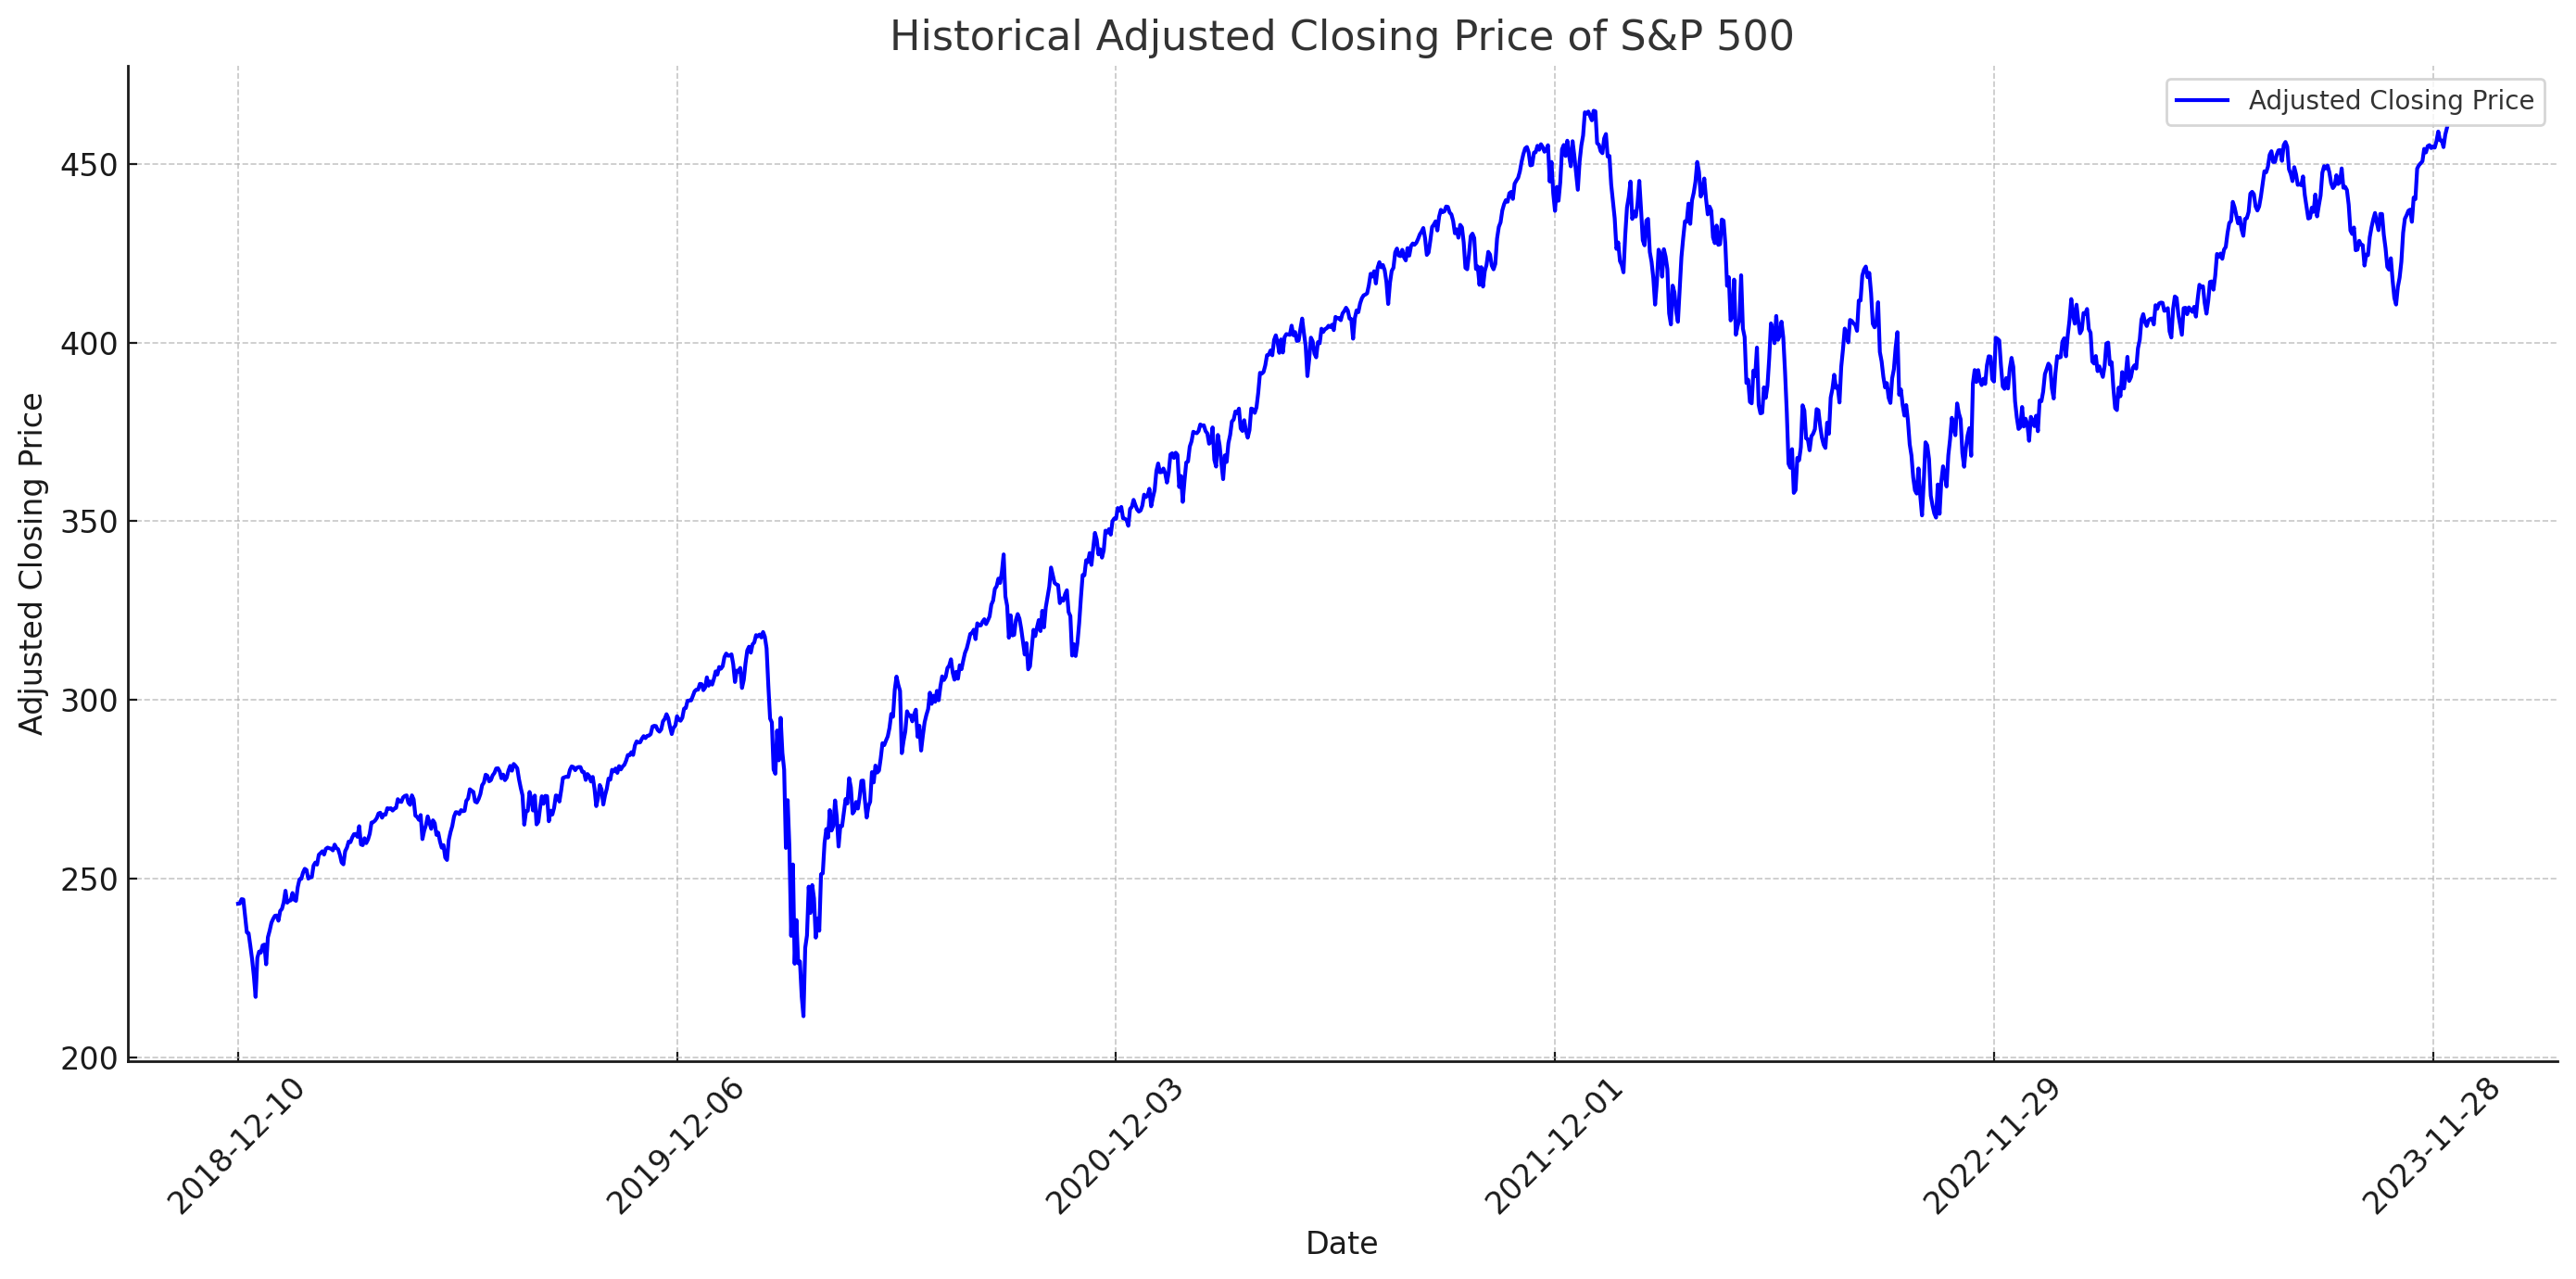

In [40]:
from IPython.display import Image

# Display the image
Image(filename='image.png')


# Optional: Delete Assistant and All Files

In [36]:
my_assistants = client.beta.assistants.list(
    order="desc",
    limit="20",
)
response = client.beta.assistants.delete(my_assistants.data[0].id)
print(response)

AssistantDeleted(id='asst_XKWhGGdL8AKVnDDAn18M1ndq', deleted=True, object='assistant.deleted')


In [43]:
for file in client.files.list():
    client.files.delete(file.id)

In [44]:
client.files.list()

SyncPage[FileObject](data=[], object='list', has_more=False)